# Computing the Grad-CAM on a pretrained model

In this notebook we will first pretrain a model without Grad-CAM, then show how to compute the Grad-CAM on it.

## Setup

First we will install required packages and import them,

In [1]:
%pip install -U numpy flax optax datasets einops scikit-learn tqdm git+https://github.com/codymlewis/flax_gradcam.git

import math
import matplotlib.pyplot as plt
import numpy as np
import jax
import jax.numpy as jnp
import flax.linen as nn
from flax.training.train_state import TrainState
import optax
import datasets
import einops
from sklearn import metrics
from tqdm.auto import trange
import fgradcam

Next, we define our training function,

In [2]:
@jax.jit
def update_step(train_state, X, Y):
    def loss_fn(params):
        logits = jnp.clip(train_state.apply_fn(params, X), 1e-15, 1 - 1e-15)
        one_hot = jax.nn.one_hot(Y, logits.shape[-1])
        return -jnp.mean(jnp.einsum("bl,bl -> b", one_hot, jnp.log(logits)))

    loss, grads = jax.value_and_grad(loss_fn)(train_state.params)
    train_state = train_state.apply_gradients(grads=grads)
    return loss, train_state

Then an accuracy function to see how well our model went,

In [3]:
def accuracy(train_state, X, Y, batch_size=1000):
    """
    Calculate the accuracy of the model across the given dataset

    Arguments:
    - model: Model function that performs predictions given parameters and samples
    - variables: Parameters and other learned values used by the model
    - X: The samples
    - Y: The corresponding labels for the samples
    - batch_size: Amount of samples to compute the accuracy on at a time
    """
    @jax.jit
    def _apply(batch_X):
        return jnp.argmax(train_state.apply_fn(train_state.params, batch_X), axis=-1)

    preds, Ys = [], []
    for i in range(0, len(Y), batch_size):
        i_end = min(i + batch_size, len(Y))
        preds.append(_apply(X[i:i_end]))
        Ys.append(Y[i:i_end])
    return metrics.accuracy_score(jnp.concatenate(Ys), jnp.concatenate(preds))

And a model loading function, we will load the Fashion MNIST dataset,

In [4]:
def load_mnist():
    """
    Load the Fashion MNIST dataset http://arxiv.org/abs/1708.07747

    Arguments:
    - seed: seed value for the rng used in the dataset
    """
    ds = datasets.load_dataset("fashion_mnist")
    ds = ds.map(
        lambda e: {
            'X': einops.rearrange(np.array(e['image'], dtype=np.float32) / 255, "h (w c) -> h w c", c=1),
            'Y': e['label']
        },
        remove_columns=['image', 'label']
    )
    features = ds['train'].features
    features['X'] = datasets.Array3D(shape=(28, 28, 1), dtype='float32')
    ds['train'] = ds['train'].cast(features)
    ds['test'] = ds['test'].cast(features)
    ds.set_format('numpy')
    return {t: {"X": ds[t]['X'], "Y": ds[t]['Y']} for t in ['train', 'test']}

Finally, we define our model to train,

In [5]:
class CNN(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Conv(features=48, kernel_size=(3, 3), padding="SAME")(x)
        x = nn.relu(x)
        x = nn.Conv(features=32, kernel_size=(3, 3), padding="SAME")(x)
        x = nn.relu(x)
        x = nn.Conv(features=16, kernel_size=(3, 3), padding="SAME")(x)
        x = nn.relu(x)
        x = einops.rearrange(x, "b h w c -> b (h w c)")
        x = nn.Dense(10)(x)
        x = nn.softmax(x)
        return x

## Pretraining

We will now perform pretraining of the model,

In [6]:
# Setup the dataset and model
dataset = load_mnist()
model = CNN()
train_state = TrainState.create(
    apply_fn=model.apply,
    params=model.init(jax.random.PRNGKey(42), dataset['train']['X'][:1]),
    tx=optax.sgd(0.1),
)

# Train the model
rng = np.random.default_rng()
for _ in (pbar := trange(3)):
    idxs = np.array_split(rng.permutation(len(dataset['train']['Y'])), math.ceil(len(dataset['train']['Y']) / 128))
    loss_sum = 0.0
    for idx in idxs:
        loss, train_state = update_step(train_state, dataset['train']['X'][idx], dataset['train']['Y'][idx])
        loss_sum += loss
    pbar.set_postfix_str(f"LOSS: {loss_sum / len(idxs):.3f}")
print(f"Final accuracy: {accuracy(train_state, dataset['test']['X'], dataset['test']['Y']):.3%}")

  0%|          | 0/3 [00:00<?, ?it/s]

Final accuracy: 86.920%


## Computing the Grad-CAM

To compute the Grad-CAM of the pretrained model, we must first correct a couple of things for setup, the model definition and the model parameters.

For the model definition, we must add a call of `fgradcam.observe` after the layer we want ot visualize with Grad-CAM,

In [7]:
class CNN2(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Conv(features=48, kernel_size=(3, 3), padding="SAME")(x)
        x = nn.relu(x)
        x = nn.Conv(features=32, kernel_size=(3, 3), padding="SAME")(x)
        x = nn.relu(x)
        x = nn.Conv(features=16, kernel_size=(3, 3), padding="SAME")(x)
        x = nn.relu(x)
        x = fgradcam.observe(self, x)  # We add only this line for the visualization
        x = einops.rearrange(x, "b h w c -> b (h w c)")
        x = nn.Dense(10)(x)
        x = nn.softmax(x)
        return x

Next, we setup the model and the parameters, we create blank parameters and transfer the pretrained parameters into the correct place in the PyTree,

In [8]:
model2 = CNN2()
variables = model2.init(jax.random.PRNGKey(0), dataset['train']['X'][:1])
variables['params'] = train_state.params['params']
train_state2 = TrainState.create(
    apply_fn=model2.apply,
    params=variables,
    tx=optax.sgd(0.1),
)

And finally, with our setup done, we can compute and visualize our Grad-CAMs

Computing Grad-CAM heatmap...
Done. Plotting the results...


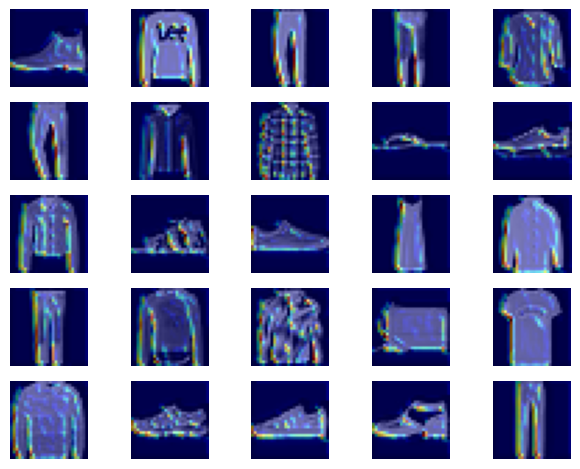

In [9]:
batch_size = 25
print("Computing Grad-CAM heatmap...")
heatmap = fgradcam.compute(train_state2, dataset['test']['X'][:batch_size])
print("Done. Plotting the results...")
fig, axes = plt.subplots(nrows=round(batch_size**0.5), ncols=round(batch_size**0.5))
axes = axes.flatten()
for i, ax in enumerate(axes):
    fgradcam.plot(dataset['test']['X'][i], heatmap[i], ax=ax)
plt.tight_layout()
plt.show()